In [1]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
import numpy as np

import pandas as pd
import sys, os, time
from scipy.stats import norm
import matplotlib.pyplot as plt

%matplotlib inline

sys.path.append('../')

from src.data_structures import FactorGraph, PriorityQueue
from src.sampling_algorithms.event_time_samplers import gaussian_bounce, chain_bounce_fn
from src.utils import gaussian_grad_potential_fn, gaussian_chain_grad_potential_fn, interp, get_xtv, get_first_moment, get_second_moment, get_var
from src.sampling_algorithms import LocalBPS
from src.plots.arrow_plot import arrow_plot
from arviz.stats import ess

from matplotlib import rc
rc('text', usetex=False)

In [3]:
d = 1
groups = 10
N = 10

def logistic(x):
    return 1/(1+np.exp(-x))

beta0 = np.random.randn(d)
betas = []
observations = []
covs = []

for g in range(groups):
    beta = beta0 + 2.*np.random.randn(d)
    betas.append(beta)
    
    cov = np.random.rand(d*N).reshape(N,d)*2.-1.
    covs.append(cov)
    p = logistic(cov.dot(beta))
    y = (np.random.random(len(p)) < p)+0.
    observations.append(y)
    
covs = np.array(covs)
observations = np.array(observations)

In [4]:
def lambda_r(v,x,t,covariates, y):
    e = np.exp(covariates.dot(x))
    return np.maximum(0.,(covariates*(e/(1+e)-y)).dot(v))

def lambda_bound(v):
    return np.sum(np.abs(v))

def grad_logistic(covariates, obs):
    def grad_fn(x):
        e = np.exp(covariates.dot(x)).reshape(N,1)
        y = obs.reshape(N,1)
        return (covariates*e/(1+e)-y).sum(0)
    return grad_fn


def generate_logistic_bounce(covariates, y, limit=100, debug=False):
    def logistic_bounce(x,v):
        accepted = False
        count = 0
        while not accepted:
            count += 1
            lambda_sim = lambda_bound(v)
            u1 = np.random.rand()
            u2 = np.random.rand()
            t = -np.log(u1)/lambda_sim
            acc = lambda_r(v,x,t, covariates, y)/lambda_sim
            if debug:
                print(acc)
            if u2 < acc:
                accepted = True
            if count > limit:
                return float('inf'), 'B'
        return t, 'B'
    return logistic_bounce

def aggregate_bounce(bounce_fns):
    def bounce_fn(x,v):
        return np.min([fn(x,v)[0] for fn in bounce_fns]), 'B'
    return bounce_fn

In [5]:
cov_p = np.maximum(0., covs)
cov_n = -np.minimum(0., covs)
sign = np.expand_dims((-1.)**(observations), -1)


def alias_sample(i, cov_n, cov_p, covs, sign, observations):
    
    s = sign[i]
    cp = cov_p[i]
    cn = cov_n[i]
    y = observations[i]
    cov = covs[i]
    
    def bounce_fn(x,v):
        pos = (v*s)>=0
        neg = (v*s)<0
        ms = np.abs(v) * (pos*cp + neg*cn) + 1e-8
        
        m_i = np.sum(ms,0)
        m = np.sum(m_i)

        p = m_i/m

        k, = np.random.multinomial(1,p, size=1).ravel().nonzero()
        p = ms[:,k].flatten() / m_i[k]
        r, = np.random.multinomial(1,p, size=1).ravel().nonzero()
        
        u = np.random.rand()
        t = -np.log(u)/m
        if np.random.rand() < lambda_r(v,x,t,cov[r], y[r])/m:
            token = 'B'
        else:
            token = 'NB'
        return t, token
    return bounce_fn

In [6]:
mu0 = np.array([0. for _ in range(d)])
sig0 = np.diag([1. for _ in range(d)])
mu1 = np.array([0. for _ in range(d)])
mu2 = np.array([0.])
sig1 = np.diag([1. for _ in range(d)])
sig2 = np.array([[1.]])
sig12 = np.array([[0.5] for _ in range(d)])

global_event_samplers = []
local_event_samplers = []

for g in range(groups):
    global_event_samplers.append(chain_bounce_fn(mu1, mu2, sig1, sig2, sig12))
    #covariates = covs[g]
    #y = observations[g]
#     bounce_fns = [generate_logistic_bounce(covariates[r], y[r]) for r in range(N)]
#     bounce_fn = aggregate_bounce(bounce_fns)
#     local_event_samplers.append(bounce_fn)
    local_event_samplers.append(alias_sample(g, cov_n, cov_p, covs, sign, observations))
    
    
bounce_fns = [gaussian_bounce(mu0, sig0)] + global_event_samplers + local_event_samplers

grad_factor_potential_fns = [gaussian_grad_potential_fn(mu0, sig0)] + \
[gaussian_chain_grad_potential_fn(mu1, mu2, sig1, sig12, sig2) for _ in range(groups)] + \
[grad_logistic(covs[g], observations[g]) for g in range(groups)]


inv_sig2 = np.linalg.pinv(sig2)
transform = np.dot(sig12, inv_sig2)
sig_bar = sig1 - np.dot(transform, sig12.T)
inv_sig = np.linalg.inv(sig_bar)
dim_x1 = len(mu1)
mu = np.concatenate([mu1, mu2], 0)
t2 = np.concatenate([-transform, np.diag(np.repeat(1., dim_x1))], 1)


factor_indices = [[i for i in range(d)]] + \
                 [[0]+[d + d*i +j for j in range(d)] for i in range(groups)] + \
                 [[d + d*i +j for j in range(d)] for i in range(groups)] 

factor_potential_fns = [lambda x: x for _ in grad_factor_potential_fns]

nodes = list(set(n for f in factor_indices for n in f ))


graph = FactorGraph(dim_x=len(nodes),
                          factor_indices=factor_indices,
                          factor_potential_fns=factor_potential_fns,
                          grad_factor_potential_fns=grad_factor_potential_fns)

In [7]:
init_x = np.random.randn(len(nodes))
init_v = np.random.randn(len(nodes))
local_bps = LocalBPS(init_x = init_x,
         init_v = init_v,
         factor_graph = graph,
         bounce_fns=bounce_fns,
         refresh_rate=1.)

24.060587406158447


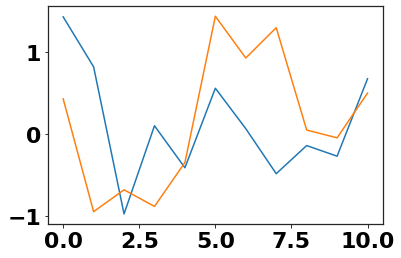

In [25]:
start = time.time()
nsim= 5*10**4
results = local_bps.simulate(nsim)
res = results
duration = time.time()-start
print(duration)

In [9]:
res.shape

(101, 3, 11)

In [20]:
betas

[array([-1.16184261]),
 array([-2.21613111]),
 array([-0.04626706]),
 array([0.79427499]),
 array([-0.23421672]),
 array([-2.13364169]),
 array([1.00018445]),
 array([-1.08040463]),
 array([-1.22130413]),
 array([-1.55649053])]

In [26]:
betas_flat = np.array(betas).flatten()
for i in range(groups+1):
    x1,v1,t1=get_xtv(res,i)
    if i < d:
        beta = beta0[i]
    else:
        beta = betas_flat[i-1]
    print('Beta {0}: {1}'.format(i, beta))
    print(get_first_moment(x1, v1, t1))

Beta 0: -1.1564219865777379
-3.500856343906023e-05
Beta 1: -1.1618426140850262
-0.025432540990675438
Beta 2: -2.216131109350963
-0.15946407314432695
Beta 3: -0.04626706115537127
0.1071289714265861
Beta 4: 0.7942749940136189
0.048456607140265145
Beta 5: -0.23421671859377635
0.0985092982225258
Beta 6: -2.1336416921687817
-0.1785878180658611
Beta 7: 1.0001844461260585
0.15705079570328276
Beta 8: -1.0804046304749484
-0.01989289587298187
Beta 9: -1.2213041335430646
-0.06608301252252495
Beta 10: -1.5564905289854734
-0.08671287437104698


In [27]:
x1,v1,t1=get_xtv(res,0)
x2,v2,t2=get_xtv(res,1)

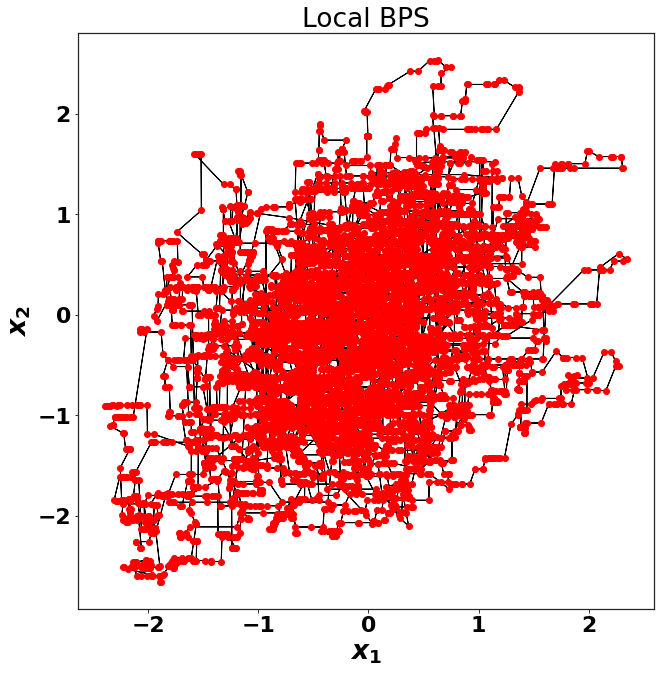

In [28]:
burnin = 40000
plot_limit = 100000
fig_size = (10,10)
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.25

font = {
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)


fig = plt.figure(figsize=fig_size,frameon =True)
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height])
ax.set_title("Local BPS")
ax.set_xlabel("$x_1$",fontsize='large', fontweight='bold')
ax.set_ylabel("$x_2$",fontsize='large', fontweight='bold')
arrow_plot(x1[burnin:burnin+plot_limit],x2[burnin:burnin+plot_limit], head_length=0.01,head_width=0.01)
fig.savefig('./local_bps.eps', format='eps', dpi=1200)



In [29]:
for i in range(len(nodes)):
    x1,v1,t1=get_xtv(res,i)
    x = interp(x1,t1,v1, num_intervals=nsim*5)
    print(ess(x)/duration)

7.684310239884513
8.733980313321759
12.457550711635836
13.345560413356381
11.077016281765895
13.117831475075441
14.037106618103053
10.948518380897559
14.063902613926444
13.14870986578646
11.496470820023346


In [15]:
x1[0], x2[0]

(-1.3609998196339907, -0.4682194358532995)

In [16]:
x1[-1], x2[-1]

(-1.0642800871031388, -1.0285943702155271)

In [17]:
beta0

array([-1.15642199])

In [18]:
betas

[array([-1.16184261]),
 array([-2.21613111]),
 array([-0.04626706]),
 array([0.79427499]),
 array([-0.23421672]),
 array([-2.13364169]),
 array([1.00018445]),
 array([-1.08040463]),
 array([-1.22130413]),
 array([-1.55649053])]